In [1]:
from __future__ import print_function, division
import os
import argparse
import torch.nn as nn
from skimage import io
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils import *
from utils.KittiColormap import *
from pyntcloud import PyntCloud
import pandas as pd
from cv_bridge import CvBridge
import cv2
import matplotlib.pyplot as plt
from datasets.data_io import get_transform, read_all_lines
from PIL import Image

## Load Data from rosbag

In [2]:
list_filename = "./filenames/kitti15_train.txt"
lines = read_all_lines(list_filename)
splits = [line.split() for line in lines]
left_filenames = [x[0] for x in splits]
right_filenames = [x[1] for x in splits]
disp_filenames = [x[2] for x in splits]

In [3]:
def load_image(filename):
    return Image.open(filename).convert('RGB')

def load_disp(filename):
    data = Image.open(filename)
    data = np.array(data, dtype=np.float32) / 256.
    return data

In [4]:
index = 0
datapath = "./datasets"
left_img = load_image(os.path.join(datapath, left_filenames[index]))
right_img = load_image(os.path.join(datapath, right_filenames[index]))
disparity = load_disp(os.path.join(datapath, disp_filenames[index]))

(376, 1241, 3)
(3, 376, 1241)


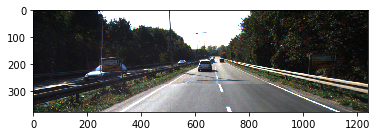

In [5]:
plt.imshow(left_img)
left_frame = np.asarray(left_img)
left_depth_rgb = left_frame[:, :, :3]
depth_rgb = np.transpose(left_depth_rgb, (2, 0, 1))
print(np.asarray(left_img).shape)
print(depth_rgb.shape)

(376, 1241)


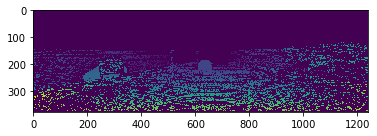

In [6]:
plt.imshow(disparity)
print(disparity.shape)

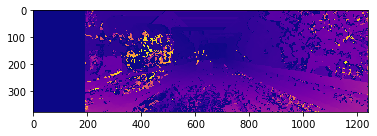

In [7]:
stereo = cv2.StereoSGBM_create(numDisparities=192, blockSize=11)
sgbm_disparity = stereo.compute(cv2.cvtColor(np.asarray(left_img), cv2.COLOR_BGR2GRAY),cv2.cvtColor(np.asarray(right_img), cv2.COLOR_BGR2GRAY))
plt.imshow(sgbm_disparity,'plasma')

In [8]:
w, h = left_img.size

# normalize
processed = get_transform()
left_img = processed(left_img).numpy()
right_img = processed(right_img).numpy()

print(left_img.shape)

# pad to size 1248x384
top_pad = 384 - h
right_pad = 1248 - w
assert top_pad > 0 and right_pad > 0
# pad images
left_img = np.lib.pad(left_img, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)
right_img = np.lib.pad(right_img, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant',
               constant_values=0)
depth_rgb = np.lib.pad(depth_rgb, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)
# pad disparity gt
if disparity is not None:
    assert len(disparity.shape) == 2
disparity = np.lib.pad(disparity, ((top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)

(3, 376, 1241)


(384, 1248)

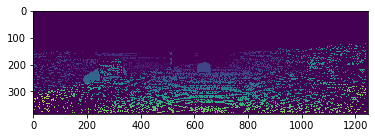

In [9]:
plt.imshow(disparity)
disparity.shape

In [10]:
from models.MSNet2D import MSNet2D
model = MSNet2D(192)
model = nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): MSNet2D(
    (feature_extraction): feature_extraction(
      (firstconv): Sequential(
        (0): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=9, bias=False)
            (4): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace=True)
            (6): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU(inplace=True)
        (2): MobileV2_Residual(
          (conv): Sequential(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [11]:
ckpt_path = "MSNet2D_SF_DS_KITTI2015.ckpt"
print("Loading model {}".format(ckpt_path))
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict['model'])

Loading model MSNet2D_SF_DS_KITTI2015.ckpt


<All keys matched successfully>

In [12]:
# Camera intrinsics and extrinsics
c_u = 6.071928e+02
c_v = 1.852157e+02
f_u = 7.188560e+02
f_v = 7.188560e+02
b_x = 4.538225e+01 / (-f_u)  # relative
b_y = -1.130887e-01 / (-f_v)

In [74]:
b_x

-0.06313121125788754

WARNING - 2022-04-13 01:32:44,656 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


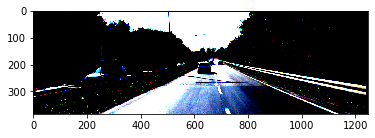

WARNING - 2022-04-13 01:32:44,840 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


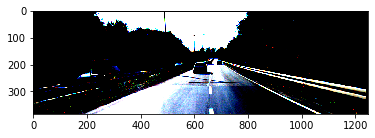

/home/chris/.local/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


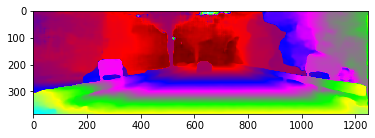

In [76]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(np.transpose(left_img, (1,2,0)))
plt.show()
plt.imshow(np.transpose(right_img, (1,2,0)))
plt.show()

sample_left = torch.Tensor(left_img)
sample_right = torch.Tensor(right_img)

sample_left = torch.unsqueeze(sample_left, dim=0)
sample_right = torch.unsqueeze(sample_right, dim=0)

with torch.no_grad():
    disp_est_tn = model(sample_left.cuda(), sample_right.cuda())[0]
    disp_est_np = tensor2numpy(disp_est_tn)
    disp_est = np.array(disp_est_np[0], dtype=np.float32)
    plt.imshow(kitti_colormap(disp_est))
    plt.show()
    disp_est[disp_est < 0] = 0
    baseline = 0.54

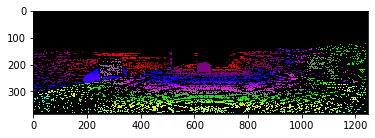

In [77]:
plt.imshow(kitti_colormap(disparity))

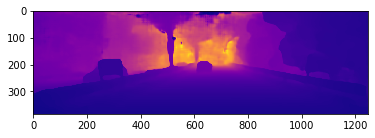

In [78]:
mask = disp_est > 0
depth = f_u * baseline / (disp_est + 1. - mask)
plt.imshow(depth, cmap="plasma")
plt.show()

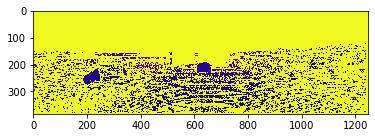

In [80]:
mask = disparity > 0
depth_gt = f_u * baseline / (disparity + 1. - mask)
plt.imshow(depth_gt, cmap="plasma")
plt.show()

In [81]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    n = uv_depth.shape[0]
    x = ((uv_depth[:, 0] - c_u) * uv_depth[:, 2]) / f_u + b_x
    y = ((uv_depth[:, 1] - c_v) * uv_depth[:, 2]) / f_v + b_y
    pts_3d_rect = np.zeros((n, 3))
    pts_3d_rect[:, 0] = x
    pts_3d_rect[:, 1] = y
    pts_3d_rect[:, 2] = uv_depth[:, 2]
    return pts_3d_rect

def project_image_to_velo(uv_depth):
    pts_3d_rect = project_image_to_rect(uv_depth)
    return pts_3d_rect

mask = disp_est > 0
rows, cols = depth.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud = project_image_to_velo(points)

mask = disparity > 0
rows, cols = depth_gt.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows))
points = np.stack([c, r, depth_gt])
points = points.reshape((3, -1))
points = points.T
points = points[mask.reshape(-1)]
cloud_gt = project_image_to_velo(points)


points_rgb = depth_rgb.reshape((3, -1)).T
points_rgb = points_rgb.astype(float)
points_rgb /= 255.

In [82]:
cloud_gt.shape

(80114, 3)

In [83]:
cloud.shape

(479232, 3)

In [84]:
points_rgb.shape

(479232, 3)

In [85]:
import open3d as o3d

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
rgbd_pcd = o3d.geometry.PointCloud()
rgbd_pcd.points = o3d.utility.Vector3dVector(cloud)
rgbd_pcd.colors = o3d.utility.Vector3dVector(points_rgb)

gt_pcd = o3d.geometry.PointCloud()
gt_pcd.points = o3d.utility.Vector3dVector(cloud_gt)

o3d.visualization.draw_geometries([rgbd_pcd, gt_pcd])

In [92]:
unit_np_pcd = o3d.geometry.PointCloud()
unit_np_pcd.points = o3d.utility.Vector3dVector(np.array([[0.0, 0.0, -0.5],[0.0, 0.0, 0.0],[0.0, 0.0, 1.0]]))
unit_np_pcd.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([rgbd_pcd, unit_np_pcd])

In [86]:
rgbd_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(rgbd_pcd,
                                                            voxel_size=0.5)

In [87]:
cloud.shape

(479232, 3)

In [88]:
rgbd_voxel_grid

VoxelGrid with 25958 voxels.

In [89]:
rgbd_voxel_grid.get_min_bound()

array([-27.01523147, -15.54876841,   4.15780497])

In [90]:
rgbd_voxel_grid.get_max_bound()

array([16.98476853,  2.95123159, 95.15780497])

In [91]:
min_mask = cloud >= [-1.2,-0.2,-2.4]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = cloud <= [1.2,1.0,0.0]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud = cloud[filter_mask]
print(filtered_cloud.shape)

(0, 3)


In [64]:
min_mask = cloud_gt >= [-1.2,-0.2,-2.4]
min_mask = min_mask[:, 0] & min_mask[:, 1] & min_mask[:, 2]
max_mask = cloud_gt <= [1.2,1.0,0.0]
max_mask = max_mask[:, 0] & max_mask[:, 1] & max_mask[:, 2]
filter_mask = min_mask & max_mask
filtered_cloud_gt = cloud_gt[filter_mask]
print(filtered_cloud_gt.shape)

(50372, 3)


In [50]:
voxel_size = 0.05 
xyz_q = np.floor(np.array(filtered_cloud/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid = np.zeros((int(2.4/voxel_size)+1, int(1.2/voxel_size)+1, int(2.4/voxel_size)+1)) #Empty voxel grid

offsets = np.array([-xyz_q[:,0].min(), -xyz_q[:,1].min(), -xyz_q[:,2].min()])
xyz_offset_q = xyz_q+offsets

vox_grid[xyz_offset_q[:,0],xyz_offset_q[:,1],xyz_offset_q[:,2]] = 1 # Setting all voxels containitn a points equal to 1
xyz_v = np.asarray(np.where(vox_grid == 1)) # get back indexes of populated voxels
empty_xyz_v = np.asarray(np.where(vox_grid == 0))

In [65]:
voxel_size = 0.05 
xyz_q_gt = np.floor(np.array(filtered_cloud_gt/voxel_size)).astype(int) # quantized point values, here you will loose precision
vox_grid_gt = np.zeros((int(2.4/voxel_size)+1, int(1.2/voxel_size)+1, int(2.4/voxel_size)+1)) #Empty voxel grid

offsets_gt = np.array([-xyz_q_gt[:,0].min(), -xyz_q_gt[:,1].min(), -xyz_q_gt[:,2].min()])
xyz_offset_q_gt = xyz_q_gt+offsets_gt

vox_grid_gt[xyz_offset_q_gt[:,0],xyz_offset_q_gt[:,1],xyz_offset_q_gt[:,2]] = 1 # Setting all voxels containitn a points equal to 1
xyz_v_gt = np.asarray(np.where(vox_grid_gt == 1)) # get back indexes of populated voxels
empty_xyz_v_gt = np.asarray(np.where(vox_grid_gt == 0))

In [66]:
cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in xyz_v.T])
empty_cloud_np = np.asarray([(pt-offsets)*voxel_size for pt in empty_xyz_v.T])

cloud_np_gt = np.asarray([(pt-offsets_gt)*voxel_size for pt in xyz_v_gt.T])


In [67]:
np_pcd = o3d.geometry.PointCloud()
np_pcd.points = o3d.utility.Vector3dVector(cloud_np)
np_pcd.paint_uniform_color([0.7, 0, 0])

np_pcd_gt = o3d.geometry.PointCloud()
np_pcd_gt.points = o3d.utility.Vector3dVector(cloud_np_gt)
np_pcd_gt.paint_uniform_color([0.0, 0.7, 0])

empty_np_pcd = o3d.geometry.PointCloud()
empty_np_pcd.points = o3d.utility.Vector3dVector(empty_cloud_np)
empty_np_pcd.paint_uniform_color([0.0, 0.7, 0])

PointCloud with 52508 points.

In [68]:
o3d.visualization.draw_geometries([rgbd_pcd, np_pcd, np_pcd_gt])

In [69]:
loss = nn.CrossEntropyLoss()

In [71]:
loss(torch.Tensor(vox_grid), torch.Tensor(vox_grid_gt))

tensor(1.4277)